In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

In [3]:


# xp = 1 Sources are from a common cause  # xp = 0 Sources are independent
# Creating the dataset
N = 50000  # length of dataset
train_ratio = 0.8  # 80% for training
train_size = int(N * train_ratio)  # number of training samples
test_size = N - train_size  # number of testing samples

def create_dataset(N=50000, train_ratio=0.8, xp=1):
    """
    Create the dataset with proper sensory input encoding.
    
    Parameters:
    -----------
    N : int
        Length of dataset
    train_ratio : float
        Ratio of training data to total data
    xp : int
        1 if sources are from a common cause, 0 if sources are independent
        
    Returns:
    --------
    train_X : array
        Training inputs (neural activations)
    test_X : array
        Testing inputs (neural activations)
    train_y : array
        Training outputs
    test_y : array
        Testing outputs
    """
    # Create basic input positions
    input_pos = np.zeros((3, N))  # Creating input position array
    input_pos[0, :] = 15 * np.random.randn(N)  # Random set of retinal hand position
    input_pos[1, :] = input_pos[0, :] + 10 * np.random.randn(N)  # Random set of associated eye position 
    input_pos[2, :] = input_pos[1, :] + 10 * np.random.randn(N)  # Random set of associated proprioceptive hand position

    # Create variances
    VarVis = (np.abs(np.random.randn(N) + 2) + 1) ** 2  # Visual variance
    VarPro = (np.abs(np.random.randn(N) + 3) + 1) ** 2  # Proprioceptive variance
    VarEye = np.zeros(N)  # Eye Position variance (assumed to be 0 in the description)
    
    # Causal inference - probability of common cause
    P_common = np.exp(-((input_pos[0, :] + input_pos[1,:] - input_pos[2, :]) ** 2) / (2 * (VarEye + VarVis + VarPro)))

    # Bayesian integration mapping
    VarTot = (VarVis + VarEye) * VarPro / (VarVis + VarEye + VarPro)
    output_fused = VarTot * ((input_pos[0, :] + input_pos[1, :]) / (VarVis + VarEye) + input_pos[2, :] / VarPro)

    # Simple input-output mapping
    VarOut_v = (VarVis + VarEye)
    VarOut_p = VarPro
    output_v = (input_pos[0, :] + input_pos[1, :])
    output_p = input_pos[2, :]
    
    if xp == 1:  # Sources are from a common cause
        output_v_total = P_common * output_fused + (1-P_common) * output_v
        output_p_total = P_common * output_fused + (1-P_common) * output_p
        VarOut_p_total = P_common * VarTot + (1-P_common) * VarPro
        VarOut_v_total = P_common * VarTot + (1-P_common) * VarOut_v
    else:  # Sources are independent
        output_v_total = output_v
        output_p_total = output_p
        VarOut_p_total = VarOut_p
        VarOut_v_total = VarOut_v

    output_separate = np.vstack((input_pos[0, :], input_pos[2, :]))  # Separate sensory estimates
    output = P_common * output_fused + (1 - P_common) * output_separate.mean(axis=0)
    
    # Now encode these inputs using the neural encoding
    
    # 1. Visual information encoding with receptive field-like population coding
    visual_input = encode_visual_input(input_pos[0, :], VarVis)
    
    # 2. Proprioceptive information of hand position with muscle-like tuning
    prop_hand_input = encode_proprioceptive_input(input_pos[2, :], VarPro, input_type="hand")
    
    # 3. Proprioceptive information of eye position with muscle-like tuning
    eye_input = encode_proprioceptive_input(input_pos[1, :], VarEye, input_type="eye")
    
    
    # Combine inputs for neural network
    X = np.vstack((visual_input, prop_hand_input, eye_input))
    
    # Prepare outputs
    y = {
        'output_v_total': output_v_total,
        'output_p_total': output_p_total,
        'var_out_v_total': VarOut_v_total,
        'var_out_p_total': VarOut_p_total
    }
    
    # Split into training and testing sets
    train_indices = np.arange(train_size)
    test_indices = np.arange(train_size, N)
    
    train_X = X[:, train_indices]
    test_X = X[:, test_indices]
    
    train_y = {key: value[train_indices] for key, value in y.items()}
    test_y = {key: value[test_indices] for key, value in y.items()}
    
    return train_X, test_X, train_y, test_y

def encode_visual_input(visual_positions, visual_variance, n_neurons=76):
    """
    Encode visual information using receptive field-like population coding
    
    Parameters:
    -----------
    visual_positions : array
        Visual positions to encode
    visual_variance : array
        Variance of the visual information
    n_neurons : int
        Number of neurons in the visual sensory group
        
    Returns:
    --------
    visual_activations : array
        Activations of visual neurons
    """
    N = len(visual_positions)
    visual_field_range = (-75, 75)  
    sigma_rf = 10  # Width of receptive field in degrees
    K = 50  # Gain factor constant
    
    # Calculate the receptive field centers for each neuron
    delta_x = (visual_field_range[1] - visual_field_range[0]) / (n_neurons - 1)
    receptive_field_centers = np.linspace(visual_field_range[0], visual_field_range[1], n_neurons)
    
    # Initialize visual activations
    visual_activations = np.zeros((n_neurons, N))
    
    # Calculate firing rates based on Gaussian tuning curves
    for i in range(n_neurons):
        firing_rates = np.exp(-((visual_positions - receptive_field_centers[i])**2) / (2 * sigma_rf**2))
        
        gain_factor = K / ( 1+visual_variance)
        adjusted_rates = firing_rates * gain_factor
        
        # Add Poisson noise
        for j in range(N):
            visual_activations[i, j] = np.random.poisson(adjusted_rates[j])
    
    return visual_activations

def encode_proprioceptive_input(positions, variance, input_type="hand", n_neurons=76):
    """
    Encode proprioceptive information (hand or eye) using muscle-like tuning
    
    Parameters:
    -----------
    positions : array
        Positions to encode
    variance : array
        Variance of the information
    input_type : str
        Type of proprioceptive input ('hand' or 'eye')
    n_neurons : int
        Number of neurons
        
    Returns:
    --------
    activations : array
        Activations of proprioceptive neurons
    """
    N = len(positions)
    max_value= np.max(np.abs(positions))
    K = 50  # Gain factor constant
    
    # Initialize activations
    activations = np.zeros((n_neurons, N))
    
    # Generate random intercepts and slopes for each neuron
    # intercepts in (-1, 1) and slopes in (-10, 10)
    np.random.seed(42 if input_type == "hand" else 43)  # Different seeds for hand and eye
    intercepts = np.random.uniform(-1, 1, n_neurons)
    slopes = np.random.uniform(-10, 10, n_neurons)
    np.random.seed(None)  # Reset seed
    
    # Calculate firing rates based on linear tuning
    for i in range(n_neurons):
        # Linear tuning with rectification ([]+)
        firing_rates = np.maximum(0, intercepts[i] + (slopes[i] * positions)/max_value)
        
        gain_factor = K / (1+variance)
        adjusted_rates = firing_rates * gain_factor
        
        # Add Poisson noise
        for j in range(N):
            activations[i, j] = np.random.poisson(adjusted_rates[j])
    
    return activations

def visualize_network_inputs(train_X, n_samples=10, save_path=None):
    """
    Visualize sample network inputs
    
    Parameters:
    -----------
    train_X : array
        Training inputs
    n_samples : int
        Number of samples to visualize
    save_path : str, optional
        Path to save the visualization
    """
    n_visual = 76
    n_prop = 76
    n_eye = 76
    
    # Get visualization samples
    vis_samples = train_X[:n_visual, :n_samples]
    prop_samples = train_X[n_visual:n_visual+n_prop, :n_samples]
    eye_samples = train_X[n_visual+n_prop:, :n_samples]
    
    # Create plot
    plt.figure(figsize=(15, 12))
    
    plt.subplot(3, 1, 1)
    plt.title("Visual Input Layer Activations (5 Samples)", fontsize=14)
    plt.imshow(vis_samples, aspect='auto', cmap='viridis')
    plt.colorbar(label="Firing Rate")
    plt.xlabel("Sample Index", fontsize=12)
    plt.ylabel("Visual Neuron", fontsize=12)
    
    plt.subplot(3, 1, 2)
    plt.title("Proprioceptive Hand Input Layer Activations", fontsize=14)
    plt.imshow(prop_samples, aspect='auto', cmap='viridis')
    plt.colorbar(label="Firing Rate")
    plt.xlabel("Sample Index", fontsize=12)
    plt.ylabel("Proprioceptive Hand Neuron", fontsize=12)
    
    plt.subplot(3, 1, 3)
    plt.title("Eye Position Input Layer Activations", fontsize=14)
    plt.imshow(eye_samples, aspect='auto', cmap='viridis')
    plt.colorbar(label="Firing Rate")
    plt.xlabel("Sample Index", fontsize=12)
    plt.ylabel("Eye Position Neuron", fontsize=12)
    
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300)
    
    return plt.gcf()


Creating dataset with neural encoding...

Dataset creation complete!
Training input shape: (228, 40000)
Testing input shape: (228, 10000)

Input layer consists of:
  - 50 visual neurons (indices 0-49)
  - 50 proprioceptive hand neurons (indices 50-99)
  - 50 eye position neurons (indices 100-149)
Total: 228 input neurons

Outputs available:
  - output_v_total: shape (40000,)
  - output_p_total: shape (40000,)
  - var_out_v_total: shape (40000,)
  - var_out_p_total: shape (40000,)

Creating visualization of sample network inputs...
Visualization saved to 'network_inputs.png'


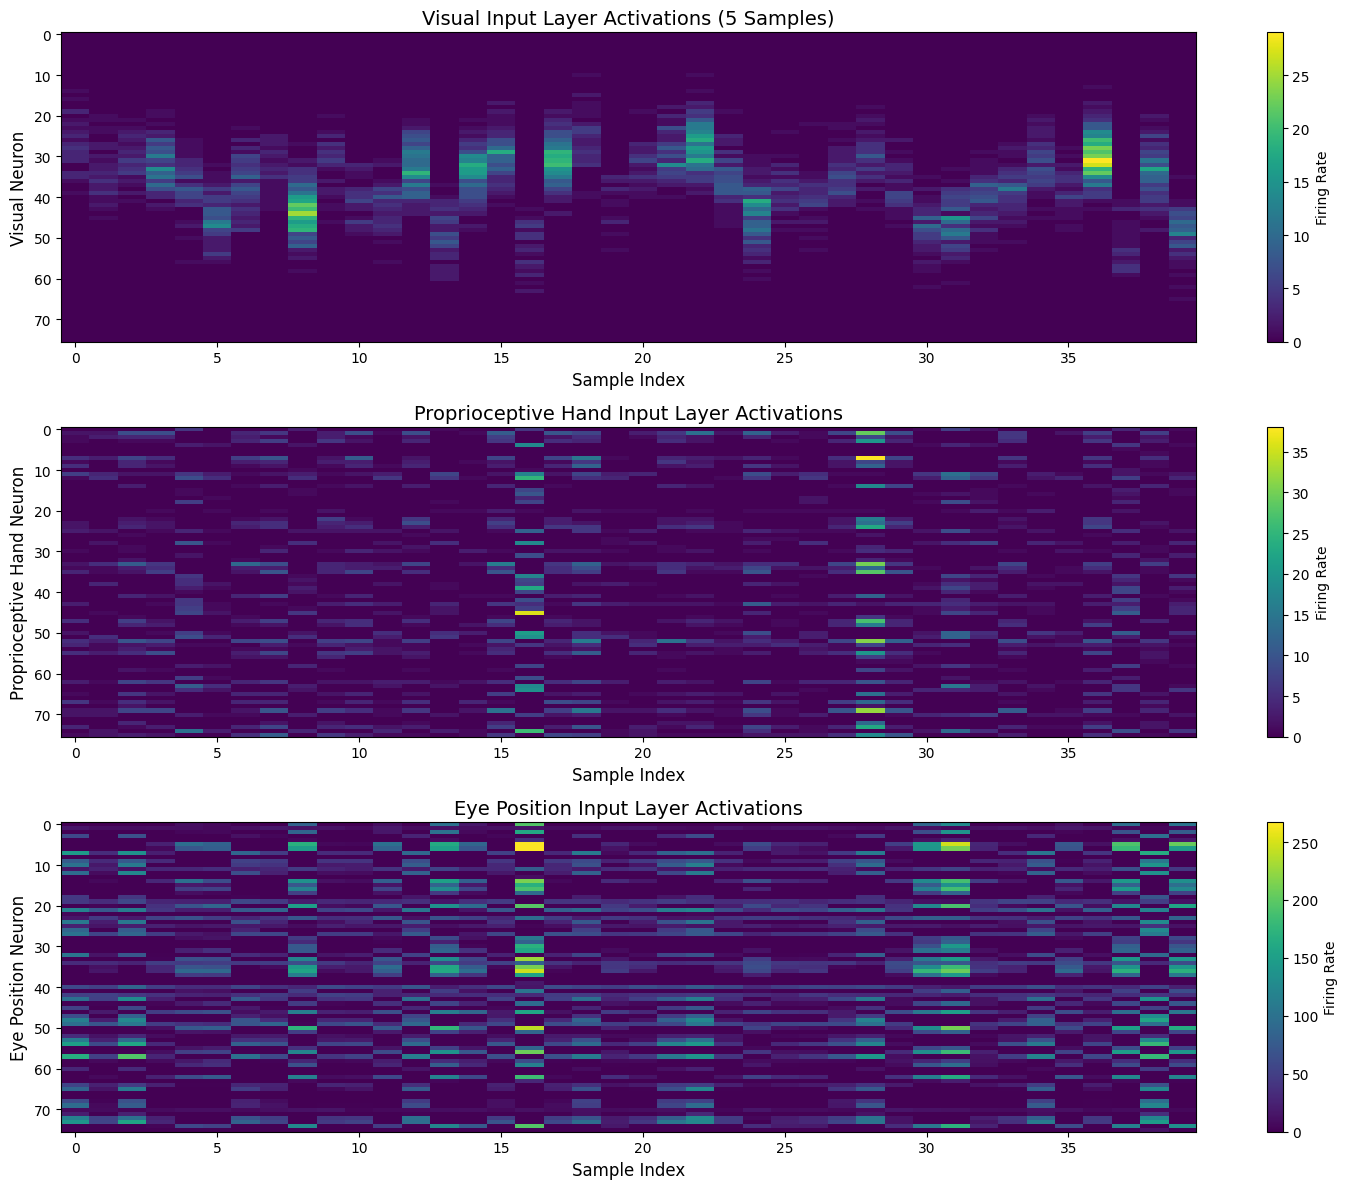

In [4]:

def main():
    print("Creating dataset with neural encoding...")
    train_X, test_X, train_y, test_y = create_dataset(N=50000, train_ratio=0.8, xp=1)
    
    print("\nDataset creation complete!")
    print(f"Training input shape: {train_X.shape}")
    print(f"Testing input shape: {test_X.shape}")
    
    print("\nInput layer consists of:")
    print(f"  - {76} visual neurons (indices 0-75)")
    print(f"  - {76} proprioceptive hand neurons (indices 76-152)")
    print(f"  - {76} eye position neurons (indices 152-228)")
    print(f"Total: {train_X.shape[0]} input neurons")
    
    print("\nOutputs available:")
    for key in train_y.keys():
        print(f"  - {key}: shape {train_y[key].shape}")
    
    # Visualize sample network inputs
    print("\nCreating visualization of sample network inputs...")
    visualize_network_inputs(train_X, n_samples=40, save_path="network_inputs.png")
    print("Visualization saved to 'network_inputs.png'")
    
    # Return dataset for further use
    return train_X, test_X, train_y, test_y

if __name__ == "__main__":
    main()

Now let's visualize tuning curves of input neurons for a single position

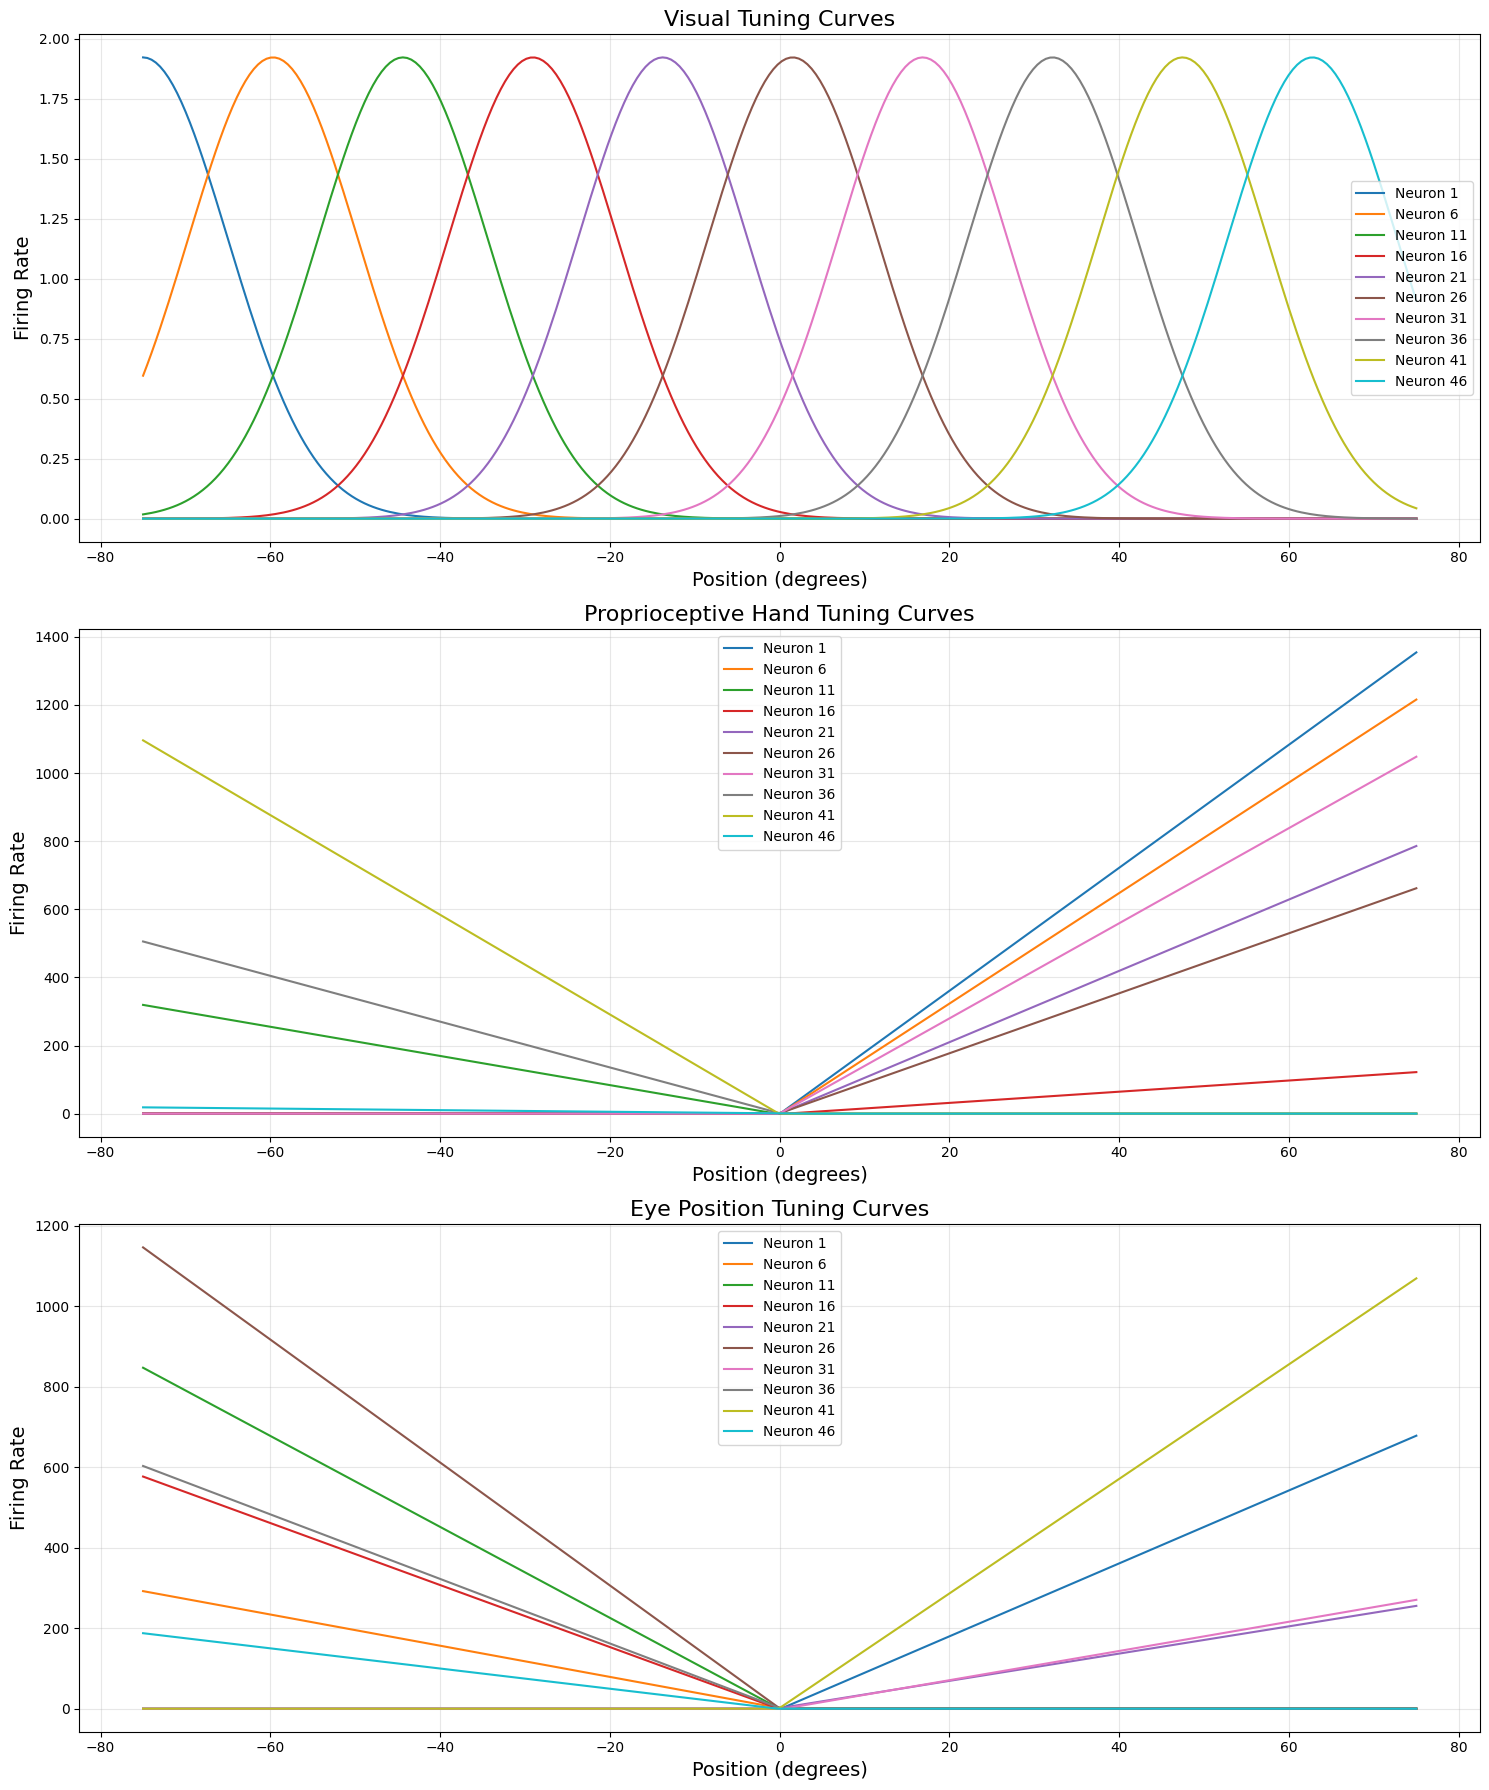

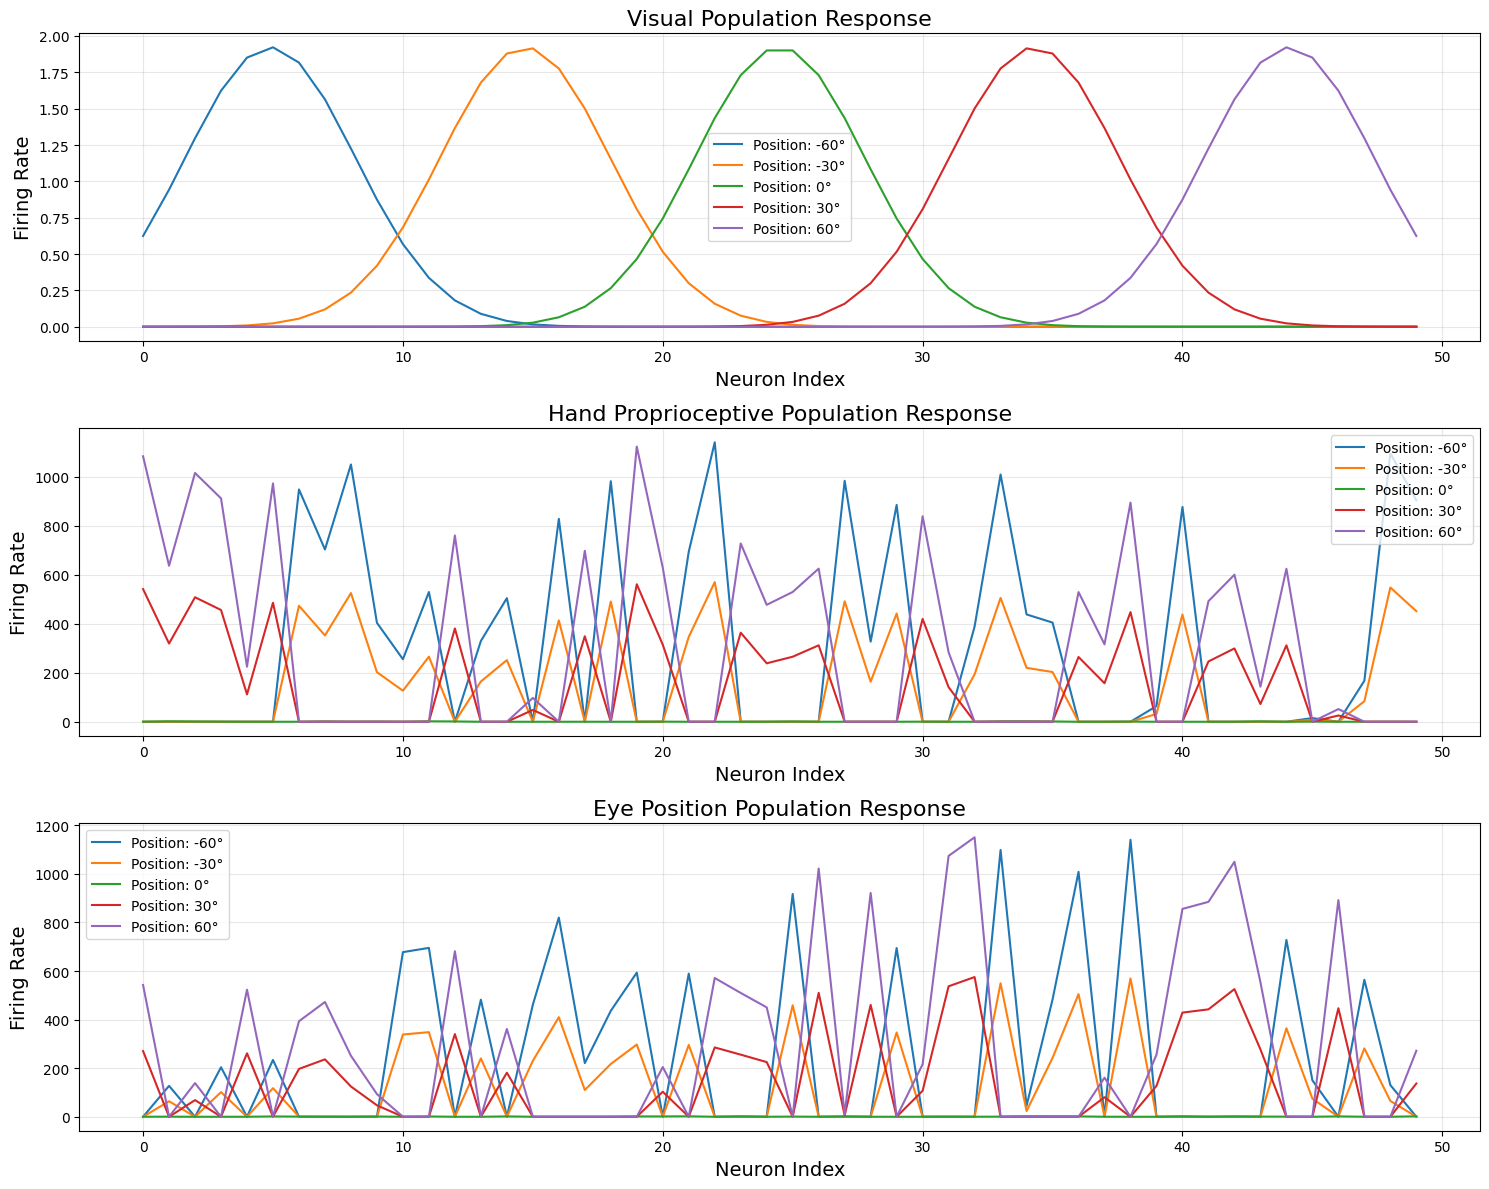

In [15]:

# 1. First define the encoding functions for single positions
def encode_visual_input_single_pos(pos, variance=25, n_neurons=76):
    """Encode a single visual position to show the tuning curve"""
    visual_field_range = (-75, 75)
    sigma_rf = 10  # Width of receptive field in degrees
    K = 50  # Gain factor constant
    
    # Calculate the receptive field centers for each neuron
    receptive_field_centers = np.linspace(visual_field_range[0], visual_field_range[1], n_neurons)
    
    # Initialize visual activations
    visual_activations = np.zeros(n_neurons)
    
    # Calculate firing rates based on Gaussian tuning curves without Poisson noise
    for i in range(n_neurons):
        
        firing_rate = np.exp(-((pos - receptive_field_centers[i])**2) / (2 * sigma_rf**2))
        gain_factor = K / (variance)
        visual_activations[i] = firing_rate * gain_factor
    
    return visual_activations, receptive_field_centers

def encode_proprioceptive_input_single_pos(pos, variance=25, input_type="hand", n_neurons=50):
    """Encode a single proprioceptive position to show the tuning curve"""
    K = 50  # Gain factor constant
    
    # Initialize activations
    activations = np.zeros(n_neurons)
    
    # Generate random intercepts and slopes for each neuron - with fixed seed for visualization
    np.random.seed(42 if input_type == "hand" else 43)  # Different seeds for hand and eye
    intercepts = np.random.uniform(-1, 1, n_neurons)
    slopes = np.random.uniform(-10, 10, n_neurons)
    
    # Calculate firing rates based on linear tuning (Equation 10)
    for i in range(n_neurons):
        # Linear tuning with rectification ([]+)
        firing_rate = max(0, intercepts[i] + slopes[i] * pos)
        
        # Apply reliability-based gain modulation
        gain_factor = K / (1 + variance)
        activations[i] = firing_rate * gain_factor
    
    return activations, intercepts, slopes

# 2. Now create a visualization function
def visualize_tuning_curves():
    # Generate positions across the visual field
    positions = np.linspace(-75, 75, 300)
    
    # Create arrays to store activations
    visual_activations = np.zeros((len(positions), 50))
    prop_hand_activations = np.zeros((len(positions), 50))
    eye_activations = np.zeros((len(positions), 50))
    
    # Compute activations for each position
    receptive_field_centers = None
    for i, pos in enumerate(positions):
        visual_activations[i], receptive_field_centers = encode_visual_input_single_pos(pos)
        prop_hand_activations[i], _, _ = encode_proprioceptive_input_single_pos(pos, input_type="hand")
        eye_activations[i], _, _ = encode_proprioceptive_input_single_pos(pos, input_type="eye")
    
    # Create figure with 3 rows for visual, hand and eye
    plt.figure(figsize=(15, 18))
    
    # 1. Visual tuning curves - Plot a subset of neurons for clarity
    plt.subplot(3, 1, 1)
    plt.title("Visual Tuning Curves", fontsize=16)
    for i in range(0, 50, 5):  # Plot every 5th neuron
        plt.plot(positions, visual_activations[:, i], label=f"Neuron {i+1}")
    plt.xlabel("Position (degrees)", fontsize=14)
    plt.ylabel("Firing Rate", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # 2. Proprioceptive hand tuning curves
    plt.subplot(3, 1, 2)
    plt.title("Proprioceptive Hand Tuning Curves", fontsize=16)
    for i in range(0, 50, 5):  # Plot every 5th neuron
        plt.plot(positions, prop_hand_activations[:, i], label=f"Neuron {i+1}")
    plt.xlabel("Position (degrees)", fontsize=14)
    plt.ylabel("Firing Rate", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # 3. Eye position tuning curves
    plt.subplot(3, 1, 3)
    plt.title("Eye Position Tuning Curves", fontsize=16)
    for i in range(0, 50, 5):  # Plot every 5th neuron
        plt.plot(positions, eye_activations[:, i], label=f"Neuron {i+1}")
    plt.xlabel("Position (degrees)", fontsize=14)
    plt.ylabel("Firing Rate", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('tuning_curves.png', dpi=300)
    plt.show()
    
    # Additionally, visualize population responses to specific positions
    plt.figure(figsize=(15, 12))
    
    # Visual population response
    plt.subplot(3, 1, 1)
    plt.title("Visual Population Response", fontsize=16)
    example_positions = [-60, -30, 0, 30, 60]
    for pos in example_positions:
        response, _ = encode_visual_input_single_pos(pos)
        plt.plot(np.arange(50), response, label=f"Position: {pos}°")
    plt.xlabel("Neuron Index", fontsize=14)
    plt.ylabel("Firing Rate", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Proprioceptive hand population response
    plt.subplot(3, 1, 2)
    plt.title("Hand Proprioceptive Population Response", fontsize=16)
    for pos in example_positions:
        response, _, _ = encode_proprioceptive_input_single_pos(pos, input_type="hand")
        plt.plot(np.arange(50), response, label=f"Position: {pos}°")
    plt.xlabel("Neuron Index", fontsize=14)
    plt.ylabel("Firing Rate", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Eye position population response
    plt.subplot(3, 1, 3)
    plt.title("Eye Position Population Response", fontsize=16)
    for pos in example_positions:
        response, _, _ = encode_proprioceptive_input_single_pos(pos, input_type="eye")
        plt.plot(np.arange(50), response, label=f"Position: {pos}°")
    plt.xlabel("Neuron Index", fontsize=14)
    plt.ylabel("Firing Rate", fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('population_responses.png', dpi=300)
    plt.show()

# 3. Call the visualization function
visualize_tuning_curves()

###### A simple review on what model we have :                          
    prop -->                                  ----> out_p
              FC1  |  FC2  |  out put layer    
    vis  -->                                  ----> out_v
    
